In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


## Importing Modules

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as mat
import seaborn as sea
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder,MinMaxScaler,PolynomialFeatures,MaxAbsScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import cross_val_score
from category_encoders import TargetEncoder

## Data Loading

In [3]:
traindf1=pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
df_test=pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
traindf=traindf1.copy()

## **EDA**

In [4]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [5]:
traindf.shape

(116023, 52)

### Let's check the case of null values in the dataset

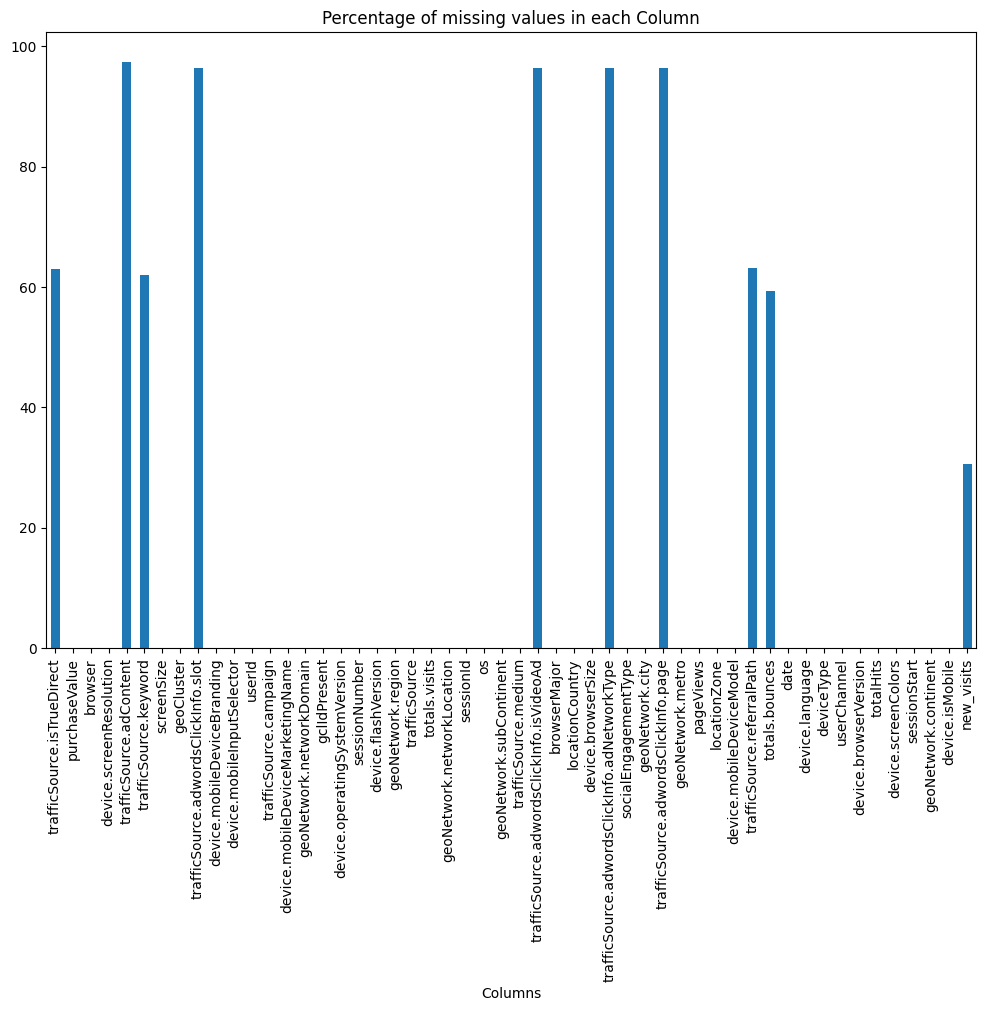

In [6]:
a=(traindf.isnull().sum()/traindf.shape[0])*100
mat.figure(figsize=(12,8))
a.plot(kind='bar')
mat.xlabel('Columns')
mat.title('Percentage of missing values in each Column')
mat.show()

From the above graph we can see that columns like 'trafficSource.isTrueDirect' , 'trafficSource.keyword' ,
'trafficSource.keyword' , 'trafficSource.adwordsClickInfo.isVideoAd' , 'trafficSource.adwordsClickingInfo.adNetworkType' ,
'trafficSource.adwordsClickInfo.page' , 'trafficSource.referralPath' ,
'totals.bouncers' have more than 60 % of its total values as null .

### Let's see how many users actually did purchase

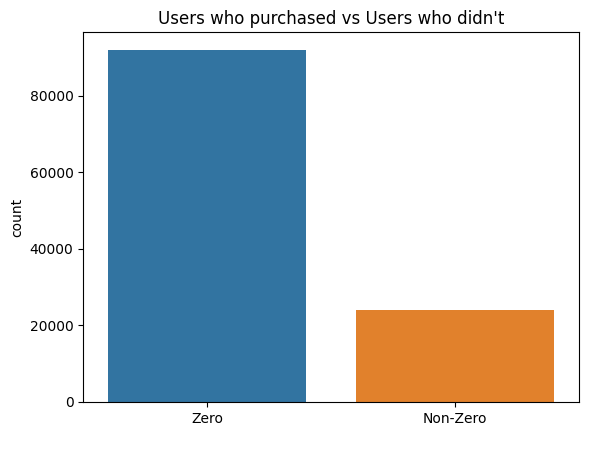

   
zero vs non-zero
Zero        92038
Non-Zero    23985
Name: count, dtype: int64
   


In [7]:
a=traindf
a['zero vs non-zero']=traindf['purchaseValue'].apply(lambda x: 'Zero' if x == 0 else 'Non-Zero')
sea.countplot(data=a,x='zero vs non-zero')
mat.xlabel(' ')
mat.title("Users who purchased vs Users who didn't")
mat.show()
print("   ")
print(a['zero vs non-zero'].value_counts())
traindf.drop('zero vs non-zero',axis=1,inplace=True)
print("   ")

### Let's check the correlation between the target column and other numeric columns and relations between them

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


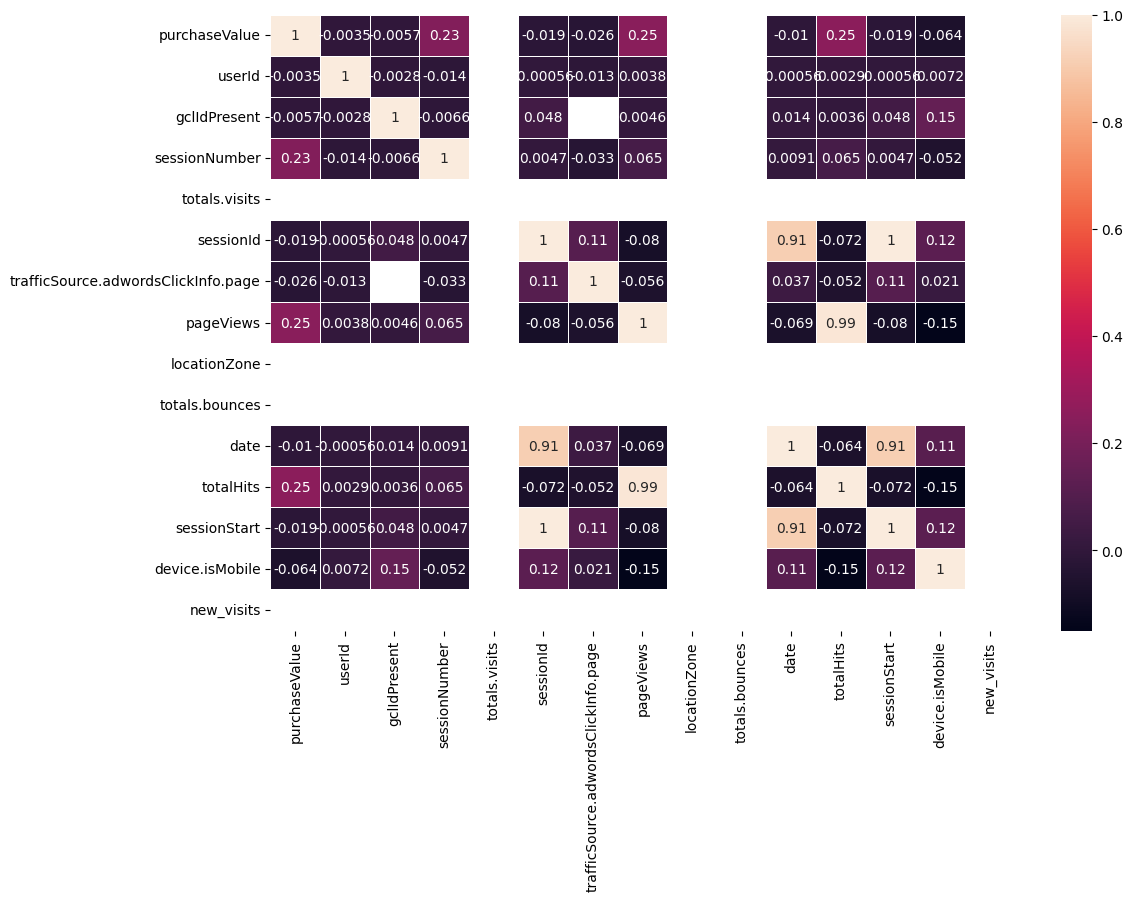

In [8]:
correlation=traindf.corr(numeric_only=True)
mat.figure(figsize=(12,8))
sea.heatmap(correlation,annot=True,linewidths=0.5)
warnings.filterwarnings("ignore", category=RuntimeWarning)
mat.show()

1)Here we can notice that there is a positive correlation between:
  'sessionId' and 'date'
 'pageView' and 'totalHits'.

2)We can also see that somehow the target column 'purchaseValue' is correlated to 'sessionNumber' , 'pageViews' and 'totalHits'.

3)We can spot that that some features like 'locationZone','totals.visits' and 'totals.bounces' and 'new_visits' have no correlation with the target column ,this indicates that for all values of the target column the values in the mentions columns might have been constant.

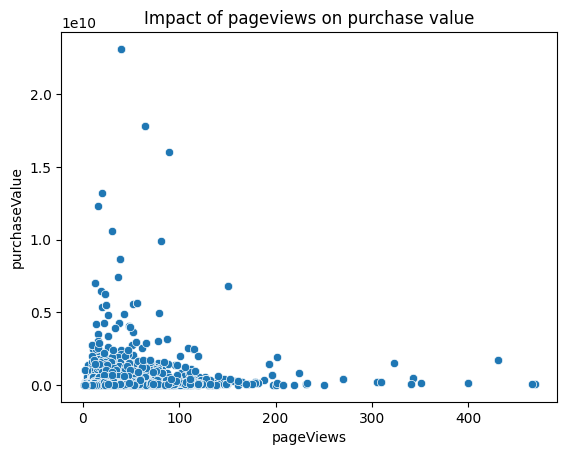

In [9]:
sea.scatterplot(data=traindf,x='pageViews',y='purchaseValue')
mat.title("Impact of pageviews on purchase value")
mat.xlabel("pageViews")
mat.ylabel("purchaseValue")
mat.show()

This shows that:

Most users have low pageViews and low purchaseValue, indicating minimal interaction.

A few users with low pageViews have very high purchaseValue, suggesting quick, high-value conversions.

As pageViews increase, purchaseValue generally decreases or stays low.

No strong positive correlation is observed between pageViews and purchaseValue.

A long tail is visible with high pageViews but low purchases.

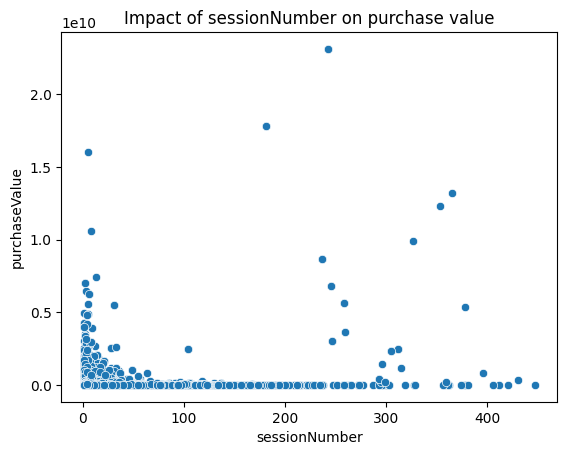

In [10]:
sea.scatterplot(data=traindf,x='sessionNumber',y='purchaseValue')
mat.title("Impact of sessionNumber on purchase value")
mat.xlabel("sessionNumber")
mat.ylabel("purchaseValue")
mat.show()

This shows that:

This shows that the relation between 'sessionNumber' and 'purchaseValue' is more
or less same as that of between 'purchaseValue' and 'pageViews' but
data is not following a particular pattern .

Most purchases occur during early sessions (low sessionNumber).

High purchase values are rare and appear across various sessionNumbers, including higher ones.

Majority of users have low or zero purchaseValue, regardless of sessionNumber.

There is no strong linear relationship between sessionNumber and purchaseValue.

A few high spikes suggest outliers or exceptional high-value sessions.

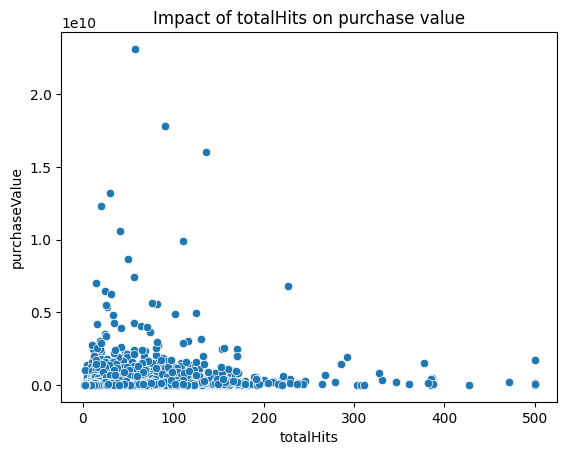

In [11]:
sea.scatterplot(data=traindf,x='totalHits',y='purchaseValue')
mat.title("Impact of totalHits on purchase value")
mat.xlabel("totalHits")
mat.ylabel("purchaseValue")
mat.show()

The relation between 'purchaseValue' and 'totalHits' is kind of same as the relation between
'pageViews' and 'purchaseValue' .

### Let's check the impact of some categorical columns on purchaseValue

            Total Users  Purchasers Conversion Rate
geoCluster                                         
Region_1          23019        4722          20.51%
Region_2          23294        4949          21.25%
Region_3          23221        4835          20.82%
Region_4          23278        4872          20.93%
Region_5          23211        4607          19.85%




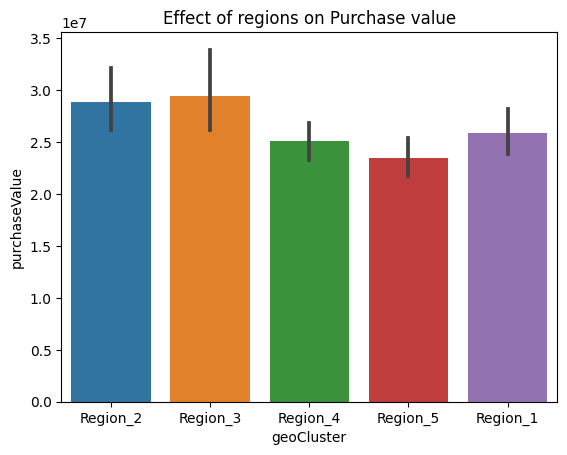

In [12]:

a=traindf['geoCluster'].value_counts()
b=traindf[traindf['purchaseValue'] > 0]['geoCluster'].value_counts()

conversion_rate = (b / a).sort_values(ascending=False)


conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)


conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'

print(conversion_df)
print('\n')

sea.barplot(data=traindf,x='geoCluster',y='purchaseValue')
mat.title('Effect of regions on Purchase value')
mat.show()



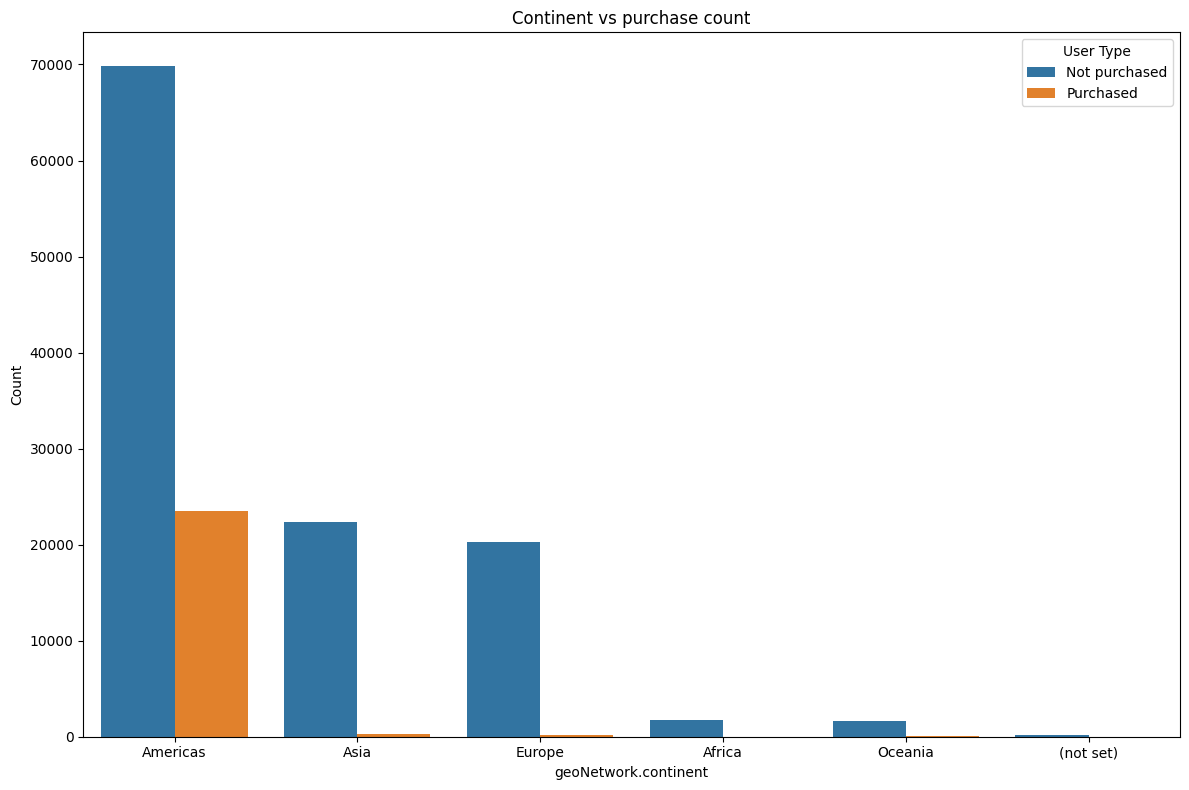

In [13]:
df = traindf.copy()
df['purchased'] = traindf['purchaseValue'] > 0

total_users = df['geoNetwork.continent'].value_counts().rename('Not purchased')
purchasers = df[df['purchased']]['geoNetwork.continent'].value_counts().rename('Purchased')

summary = pd.concat([total_users, purchasers], axis=1).fillna(0).astype(int).reset_index()
summary = summary.rename(columns={'index': 'userChannel'})

melted = summary.melt(id_vars='geoNetwork.continent', var_name='User Type', value_name='Count')
mat.figure(figsize=(12,8))
sea.barplot(data=melted, x='geoNetwork.continent', y='Count', hue='User Type')
mat.title('Continent vs purchase count')
mat.tight_layout()
mat.show()


Here we can see that users from 'Europe' have the least purchasers and users from 'Americas' have the maximum purchasers .

In [14]:
a=traindf['geoNetwork.continent'].value_counts()
b=traindf[traindf['purchaseValue'] > 0]['geoNetwork.continent'].value_counts()

conversion_rate = (b / a).sort_values(ascending=False)


conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)


conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'

print(conversion_df)

                      Total Users  Purchasers Conversion Rate
geoNetwork.continent                                         
(not set)                     136           9           6.62%
Africa                       1747          14            0.8%
Americas                    69856       23511          33.66%
Asia                        22384         257           1.15%
Europe                      20294         164           0.81%
Oceania                      1606          30           1.87%


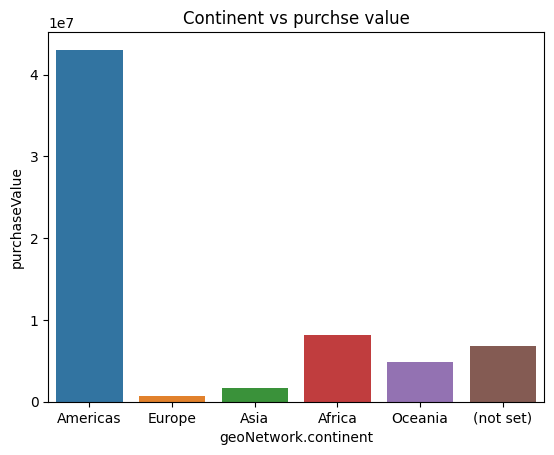

In [15]:
sea.barplot(data=traindf,x='geoNetwork.continent',y='purchaseValue',errorbar=None)
mat.title('Continent vs purchse value')
mat.show()

This shows that even though users from 'Americas' have highest average purchase value and though users from 'Africa' purchase a lot less still their average purchase value is quite high .

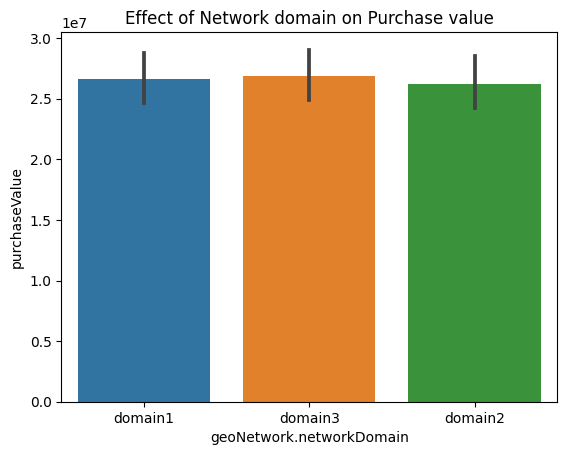

                          Total Users  Purchasers Conversion Rate
geoNetwork.networkDomain                                         
domain1                         38795        8041          20.73%
domain2                         38619        8015          20.75%
domain3                         38609        7929          20.54%


In [16]:
sea.barplot(data=traindf,x='geoNetwork.networkDomain',y='purchaseValue')
mat.title('Effect of Network domain on Purchase value')
mat.show()

a=traindf['geoNetwork.networkDomain'].value_counts()
b=traindf[traindf['purchaseValue'] > 0]['geoNetwork.networkDomain'].value_counts()

conversion_rate = (b / a).sort_values(ascending=False)


conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)


conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'

print(conversion_df)

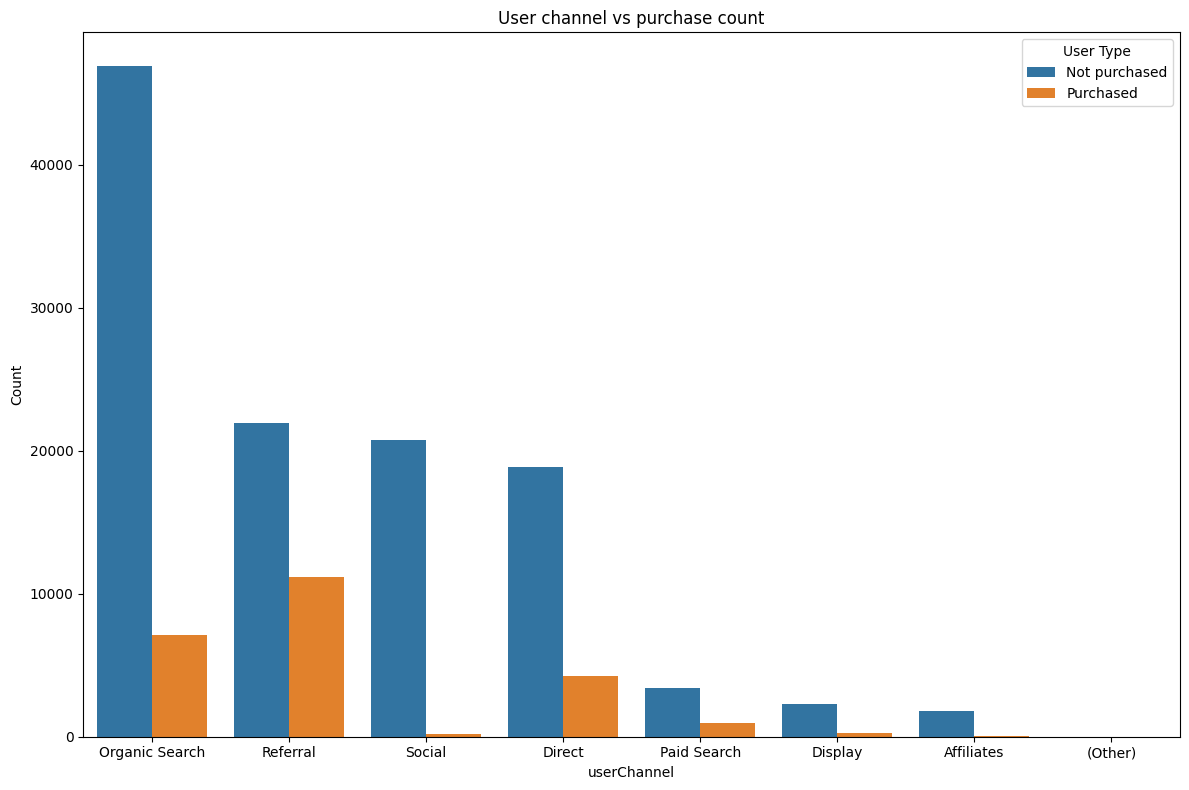

In [17]:
df = traindf.copy()
df['purchased'] = traindf['purchaseValue'] > 0

total_users = df['userChannel'].value_counts().rename('Not purchased')
purchasers = df[df['purchased']]['userChannel'].value_counts().rename('Purchased')

summary = pd.concat([total_users, purchasers], axis=1).fillna(0).astype(int).reset_index()
summary = summary.rename(columns={'index': 'userChannel'})

melted = summary.melt(id_vars='userChannel', var_name='User Type', value_name='Count')
mat.figure(figsize=(12,8))
sea.barplot(data=melted, x='userChannel', y='Count', hue='User Type')
mat.title('User channel vs purchase count')
mat.tight_layout()
mat.show()


In [18]:
a=traindf['userChannel'].value_counts()
b=traindf[traindf['purchaseValue'] > 0]['userChannel'].value_counts()

conversion_rate = (b / a).sort_values(ascending=False)


conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)


conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'

print(conversion_df)

                Total Users  Purchasers Conversion Rate
userChannel                                            
(Other)                  10           2           20.0%
Affiliates             1777          20           1.13%
Direct                18886        4251          22.51%
Display                2301         273          11.86%
Organic Search        46925        7127          15.19%
Paid Search            3406         963          28.27%
Referral              21932       11142           50.8%
Social                20786         207            1.0%


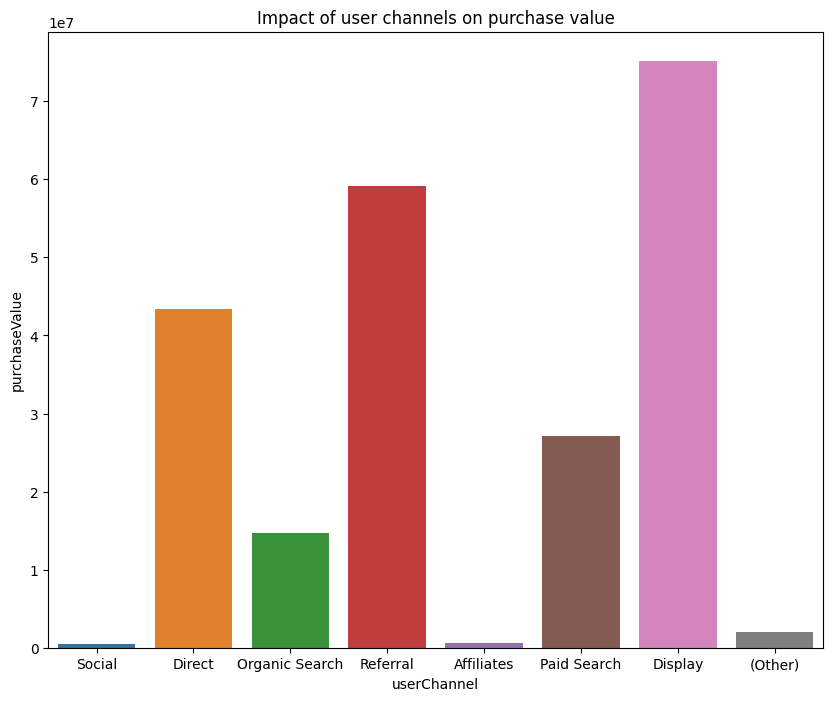

In [19]:
mat.figure(figsize=(10,8))
sea.barplot(data=traindf,x='userChannel',y='purchaseValue',errorbar=None)
mat.title("Impact of user channels on purchase value")
mat.show()

Now we can derive that users through 'Display' medium have made the most average purchase followed by users through 'Referral' medium where as mediums like 'Social' and 'Affiliates' contribute to almost have no effect on purchase .


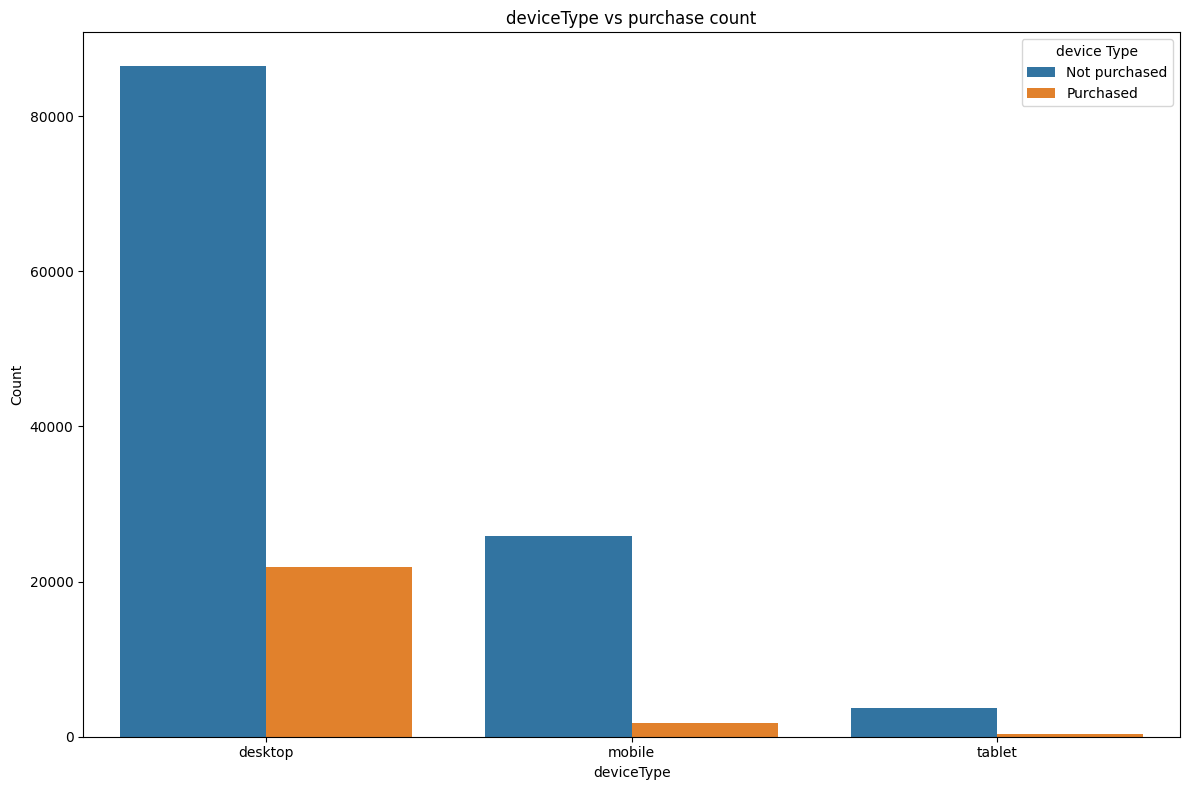

            Total Users  Purchasers Conversion Rate
deviceType                                         
desktop           86480       21884          25.31%
mobile            25850        1770           6.85%
tablet             3693         331           8.96%


In [20]:
df = traindf.copy()
df['purchased'] = traindf['purchaseValue'] > 0

total_users = df['deviceType'].value_counts().rename('Not purchased')
purchasers = df[df['purchased']]['deviceType'].value_counts().rename('Purchased')

summary = pd.concat([total_users, purchasers], axis=1).fillna(0).astype(int).reset_index()
summary = summary.rename(columns={'index': 'deviceType'})

melted = summary.melt(id_vars='deviceType', var_name='device Type', value_name='Count')
mat.figure(figsize=(12,8))
sea.barplot(data=melted, x='deviceType', y='Count', hue='device Type')
mat.title('deviceType vs purchase count')
mat.tight_layout()
mat.show()

a=traindf['deviceType'].value_counts()
b=traindf[traindf['purchaseValue'] > 0]['deviceType'].value_counts()

conversion_rate = (b / a).sort_values(ascending=False)


conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)


conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'

print(conversion_df)

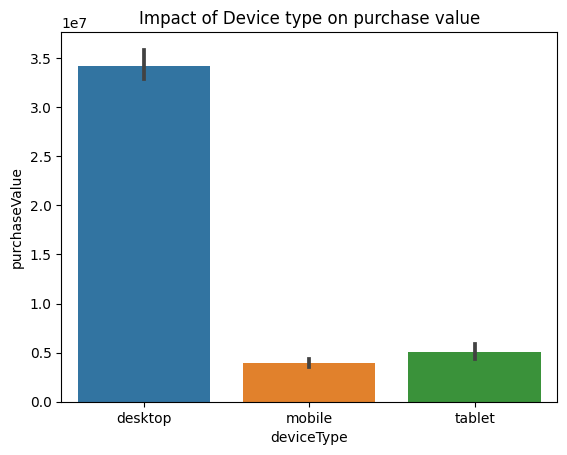

In [21]:
sea.barplot(data=traindf,x='deviceType',y='purchaseValue')
mat.title('Impact of Device type on purchase value')
mat.show()

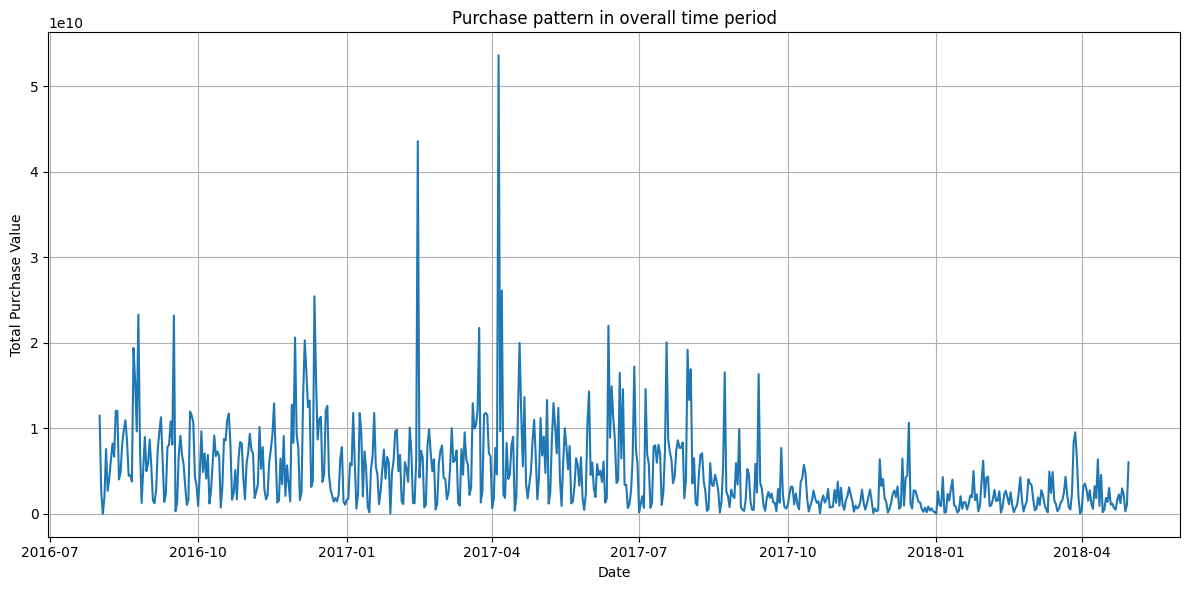

In [22]:
traindf['date'] = pd.to_datetime(traindf['date'], format='%Y%m%d')
daily_sales = traindf.groupby(traindf['date'].dt.date)['purchaseValue'].sum()


daily_sales.plot(kind='line', figsize=(12,6), title='Daily Total Purchase Value')
mat.xlabel('Date')
mat.ylabel('Total Purchase Value')
mat.title('Purchase pattern in overall time period')
mat.grid(True)
mat.tight_layout()
mat.show()

From here we can observe that:

High purchase spikes occurred occasionally, especially between late 2016 and early 2017, indicating days with unusually large transactions .

After mid-2017, there’s a declining trend in both the frequency and value of purchases .

Overall, daily purchase values are highly variable, with no clear pattern .

In [23]:
traindf['date']
traindf['day_name']=traindf['date'].dt.day_name()
traindf['sessionStart'] = pd.to_datetime(traindf['sessionStart'],unit='s')
traindf['date']=pd.to_datetime(traindf['date'], unit='s')
traindf['day_name']=traindf['day_name'].apply(lambda x:'Weekend' if x in('Sunday','Saturday') else 'Weekday')
traindf['day_name']

0         Weekday
1         Weekday
2         Weekday
3         Weekday
4         Weekday
           ...   
116018    Weekday
116019    Weekday
116020    Weekday
116021    Weekday
116022    Weekend
Name: day_name, Length: 116023, dtype: object

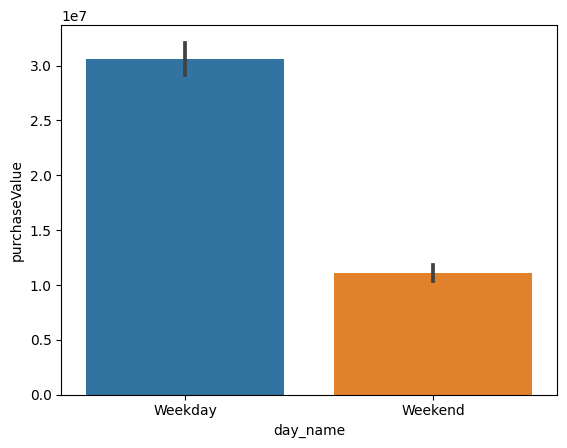

In [24]:
sea.barplot(data=traindf,x='day_name',y='purchaseValue')
mat.show()

### Top 20 Traffic sources and their conversion rates

In [25]:

a=traindf['trafficSource'].value_counts().head(20)
b=traindf[traindf['purchaseValue'] > 0]['trafficSource'].value_counts().head(20)

conversion_rate = (b / a).sort_values(ascending=False)


conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)

conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'
print(conversion_df)

                         Total Users  Purchasers Conversion Rate
trafficSource                                                   
(direct)                     36837.0     12108.0          32.87%
Partners                      1779.0        20.0           1.12%
analytics.google.com          1826.0         0.0            0.0%
baidu                          354.0         0.0            0.0%
bing                           228.0        40.0          17.54%
dealspotr.com                    0.0        71.0            0.0%
dfa                            617.0       204.0          33.06%
facebook.com                   233.0        29.0          12.45%
gdeals.googleplex.com            0.0        17.0            0.0%
google                       44332.0      6845.0          15.44%
google.com                     503.0        16.0           3.18%
groups.google.com              186.0        68.0          36.56%
l.facebook.com                   0.0        24.0            0.0%
m.facebook.com           

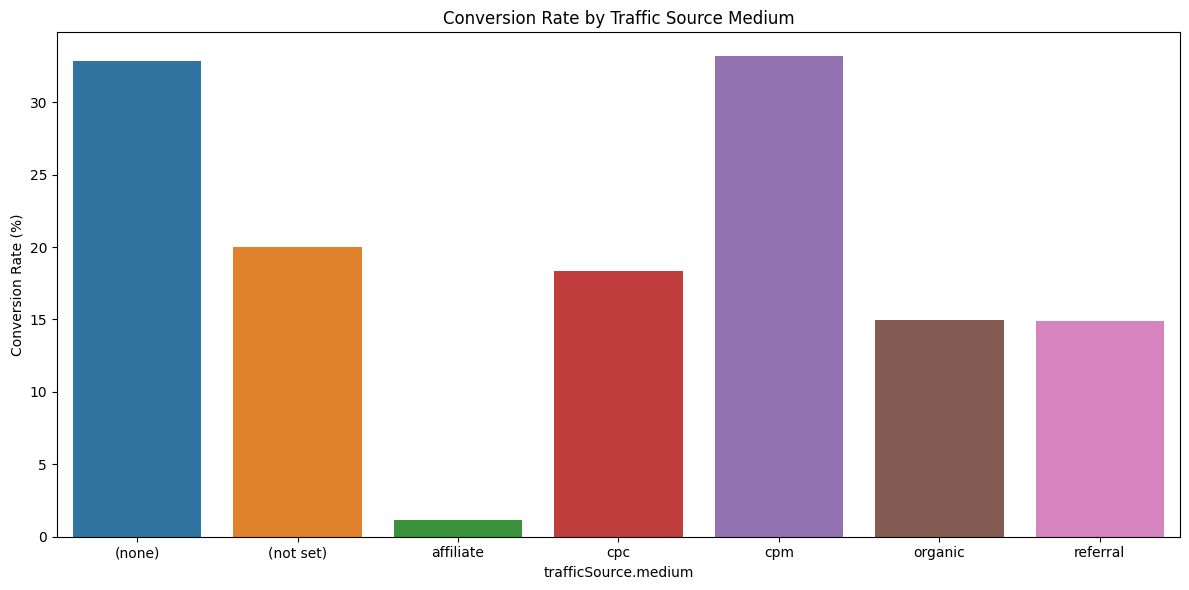

,Total Users,Purchasers,Conversion Rate
trafficSource.medium,,,
(none),36837,12108,32.87%
(not set),10,2,20.0%
affiliate,1777,20,1.13%
cpc,4286,786,18.34%
cpm,802,266,33.17%
organic,40654,6084,14.97%
referral,31657,4719,14.91%


In [26]:

a = traindf['trafficSource.medium'].value_counts()
b = traindf[traindf['purchaseValue'] > 0]['trafficSource.medium'].value_counts()

conversion_rate = (b / a).sort_values(ascending=False)
conversion_df = pd.DataFrame({
    'Total Users': a,
    'Purchasers': b,
    'Conversion Rate': conversion_rate
}).fillna(0)

conversion_df1 = conversion_df.copy()
conversion_df1['Conversion Rate'] = (conversion_df1['Conversion Rate'] * 100).round(2)
conversion_df['Conversion Rate'] = (conversion_df['Conversion Rate'] * 100).round(2).astype(str) + '%'

conversion_df1 = conversion_df1.reset_index().rename(columns={'index': 'trafficSource.medium'})


mat.figure(figsize=(12, 6))
sea.barplot(data=conversion_df1, x='trafficSource.medium', y='Conversion Rate')
mat.title('Conversion Rate by Traffic Source Medium')
mat.ylabel('Conversion Rate (%)')
mat.tight_layout()
mat.show()

conversion_df

We can derive that:
The "(none)" and "cpm" channels have the highest conversion rates.

The "(not set)" and "cpc" mediums show moderate conversion rates.

"organic" and "referral" have lower conversion rates.

The "affiliate" channel has the lowest conversion rate among all.

Overall, "none" and "cpm" channels are most effective at driving purchases, while affiliate is the least effective.

In [27]:
a = traindf.select_dtypes(include=['object']).columns.to_list()
for i in a:
    b=traindf[i].value_counts()
    print('\n')
    print(b)



trafficSource.isTrueDirect
True    42890
Name: count, dtype: int64


browser
Chrome                                                  84508
Safari                                                  19184
Firefox                                                  4031
Internet Explorer                                        2155
Android Webview                                          1472
Edge                                                     1216
Safari (in-app)                                           793
Opera Mini                                                733
Samsung Internet                                          563
Opera                                                     548
UC Browser                                                296
YaBrowser                                                 187
Amazon Silk                                                73
Coc Coc                                                    61
Android Browser                                      

In [28]:
a=traindf.select_dtypes(include=['object', 'category']).columns.tolist()
col_list=[]
for i in traindf.columns:
    b=traindf[i].value_counts()
    if len(b)<2:
        print(b)
        print('\n')
        col_list.append(i)

trafficSource.isTrueDirect
True    42890
Name: count, dtype: int64


device.screenResolution
not available in demo dataset    116023
Name: count, dtype: int64


screenSize
medium    116023
Name: count, dtype: int64


device.mobileDeviceBranding
not available in demo dataset    116023
Name: count, dtype: int64


device.mobileInputSelector
not available in demo dataset    116023
Name: count, dtype: int64


device.mobileDeviceMarketingName
not available in demo dataset    116023
Name: count, dtype: int64


device.operatingSystemVersion
not available in demo dataset    116023
Name: count, dtype: int64


device.flashVersion
not available in demo dataset    116023
Name: count, dtype: int64


totals.visits
1    116023
Name: count, dtype: int64


geoNetwork.networkLocation
not available in demo dataset    116023
Name: count, dtype: int64


trafficSource.adwordsClickInfo.isVideoAd
False    4281
Name: count, dtype: int64


browserMajor
not available in demo dataset    116023
Name: count, dtype: 

By this we can conclude that the above mentioned columns have almost 0 effect on the 'purchaseValue'.

## Preprocessing

In [29]:
x_train=traindf1.copy()
y=traindf1['purchaseValue']
#x_train,x_test,y_train,y_test=train_test_split(z,y,test_size=0.2,random_state=1729)

In [30]:
print(traindf.shape)
traindf.isna().sum().sort_values(ascending=False).head(15)

(116023, 53)


trafficSource.adContent                         113060
trafficSource.adwordsClickInfo.isVideoAd        111742
trafficSource.adwordsClickInfo.slot             111742
trafficSource.adwordsClickInfo.adNetworkType    111742
trafficSource.adwordsClickInfo.page             111742
trafficSource.referralPath                       73309
trafficSource.isTrueDirect                       73133
trafficSource.keyword                            71861
totals.bounces                                   68875
new_visits                                       35505
pageViews                                            8
device.mobileDeviceModel                             0
device.browserSize                                   0
socialEngagementType                                 0
geoNetwork.city                                      0
dtype: int64

As we can see there are many null values in the columns so we should find a way to solve this issue

In [31]:
cols_to_drop = x_train.columns[x_train.isnull().mean() > 0.9]
x_train = x_train.drop(columns=cols_to_drop, errors='ignore')
#x_test = x_test.drop(columns=cols_to_drop, errors='ignore')
df_test = df_test.drop(columns=cols_to_drop, errors='ignore')

In [32]:
def fill(zx):
    zx['trafficSource.referralPath']=zx['trafficSource.referralPath'].fillna('unknown')
    zx['trafficSource.isTrueDirect']=zx['trafficSource.isTrueDirect'].fillna('False')
    zx['trafficSource.keyword']=zx['trafficSource.keyword'].fillna('missing')
    zx['totals.bounces']=zx['totals.bounces'].fillna(0)
    zx['new_visits']=zx['new_visits'].fillna(0)
    zx['pageViews']=zx['pageViews'].fillna(zx['pageViews'].median())
    zx=zx.replace("not available in demo dataset", "missing")
    return zx

x_train=fill(x_train)
#x_test=fill(x_test)
df_test=fill(df_test)

## Total sessions of user and avg purchase

In [33]:
#x_train['user_Sessions'] = x_train.groupby('userId')['sessionNumber'].transform('count')
userAvgPurchase = x_train[x_train['purchaseValue']>0].groupby('userId')['purchaseValue'].mean()
x_train['useravgPurchase'] = x_train['userId'].map(userAvgPurchase)
x_train['useravgPurchase'].fillna(x_train['useravgPurchase'].median())


#df_test['user_Sessions'] = df_test.groupby('userId')['sessionNumber'].transform('count')
df_test['useravgPurchase'] = df_test['userId'].map(userAvgPurchase)
df_test['useravgPurchase']=df_test['useravgPurchase'].fillna(x_train['useravgPurchase'].median())

In [34]:
x_train['user_Sessions'] = x_train.groupby('sessionId')['sessionNumber'].transform('count')
df_test['user_Sessions'] = df_test.groupby('sessionId')['sessionNumber'].transform('count')

In [35]:
purchase_by_browser = x_train.loc[x_train['purchaseValue'] > 0, 'browser'].value_counts()
total_by_browser = x_train['browser'].value_counts()
browser_conversion_ratio = (purchase_by_browser / total_by_browser).fillna(0)
x_train['browserConversionRatio'] = x_train['browser'].map(browser_conversion_ratio).fillna(0)
df_test['browserConversionRatio'] = df_test['browser'].map(browser_conversion_ratio).fillna(0)

## Interaction Features

In [36]:
def interaction(df):
    df['device_medium'] = df['deviceType'] + '_' + df['trafficSource.medium']
    df['views_per_session'] = df['pageViews'] / (df['sessionNumber']).replace(0, 1)
    df['month']=pd.to_datetime(df['sessionStart']).dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df.drop(columns='month',inplace=True)
    df['dayofweek'] = pd.to_datetime(df['sessionStart']).dt.dayofweek 
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df.drop(columns='dayofweek', inplace=True)
    df['sessionPerInteraction'] = df['sessionNumber'] / (df['user_Sessions']).replace(0,1)
    
    
    df['pageViews'] = np.log1p(df['pageViews'])
    df['totalHits'] = np.log1p(df['totalHits'])
    df['sessionNumber'] = np.log1p(df['sessionNumber'])


    
    df['hitsPerPageview']=df['totalHits']/(df['pageViews']).replace(0,1)
    df['pageViewsXTotalHits']=df['pageViews']*df['totalHits']
    df['activeSession'] = (df['pageViews'] + df['totalHits']) / (df['sessionNumber']+1)
    df['userInteraction'] = (df['pageViewsXTotalHits']) / (df['sessionNumber']+1e-4)#.replace(0,1)
    df['user_focus'] = (df['pageViews']**2 + df['totalHits']**2) / (df['sessionNumber'] + 1e-4)

    df['engagement_depth'] = df['hitsPerPageview'] * df['activeSession']
    df['sessionNumber_userSessions'] = df['sessionNumber'] * df['user_Sessions']
    df['unlikely_to_purchase'] = ((df['totals.bounces'] == 1) & (df['new_visits'] == 1)).astype(int)

   
    return df

x_train=interaction(x_train)
#x_test=interaction(x_test)
df_test=interaction(df_test)

## Dropping high values and singular category columns

In [37]:
def dropagain(x):
    cols = [
        "device.screenResolution","device.mobileDeviceBranding","device.mobileInputSelector",
        "device.operatingSystemVersion","device.browserSize","browserMajor","device.language",
        "device.browserVersion","device.mobileDeviceModel","device.screenColors","geoNetwork.networkLocation",
        "screenSize","socialEngagementType","trafficSource.keyword","trafficSource.campaign",
        "device.mobileDeviceMarketingName","device.flashVersion",'geoNetwork.region',
        "geoNetwork.metro","trafficSource.referralPath","geoNetwork.city",'locationZone'
    ]
    x=x.drop(columns=cols)
    x['device.isMobile']=x['device.isMobile'].astype(str)
    x['trafficSource.isTrueDirect']=x['trafficSource.isTrueDirect'].astype(str)

    return x

x_train=dropagain(x_train)
#x_test=dropagain(x_test)
df_test=dropagain(df_test)

In [38]:
numeric = x_train.select_dtypes(include= ['int64','float64']).columns
x_train[numeric].corr()['purchaseValue'].sort_values(ascending=False)

purchaseValue                 1.000000
useravgPurchase               0.655442
sessionNumber_userSessions    0.254440
pageViewsXTotalHits           0.248653
totalHits                     0.226247
pageViews                     0.225725
sessionNumber                 0.178228
user_Sessions                 0.176235
sessionPerInteraction         0.158351
userInteraction               0.152588
user_focus                    0.152526
engagement_depth              0.149843
activeSession                 0.149184
views_per_session             0.130205
hitsPerPageview               0.059238
browserConversionRatio        0.048372
userId                       -0.003469
gclIdPresent                 -0.005652
date                         -0.010338
sessionStart                 -0.018537
sessionId                    -0.018537
unlikely_to_purchase         -0.089608
totals.bounces               -0.107116
new_visits                   -0.123070
totals.visits                      NaN
month_sin                

In [39]:
def dropall(x):

    top_25 = x['locationCountry'].value_counts().nlargest(25).index
    x['locationCountry'] = x['locationCountry'].apply(lambda a: a if a in top_25 else 'others')

    top_25 = x['trafficSource'].value_counts().nlargest(25).index
    x['trafficSource'] = x['trafficSource'].apply(lambda a: a if a in top_25 else 'others')

    top_25 = x['geoNetwork.subContinent'].value_counts().nlargest(25).index
    x['geoNetwork.subContinent'] = x['geoNetwork.subContinent'].apply(lambda a: a if a in top_25 else 'others')

    top_10 = x['browser'].value_counts().nlargest(8).index
    x['browser'] = x['browser'].apply(lambda a: a if a in top_10 else 'others')
    
    cols=['sessionId','userId','sessionStart','date','purchaseValue','totals.bounces','purchased','totals.visits']
    x=x.drop(columns=[i for i in cols if i in x.columns])
    return x

x_train=dropall(x_train)
#x_test=dropall(x_test)
df_test=dropall(df_test)
x_train.shape

(116023, 36)

In [40]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   trafficSource.isTrueDirect  116023 non-null  object 
 1   browser                     116023 non-null  object 
 2   geoCluster                  116023 non-null  object 
 3   geoNetwork.networkDomain    116023 non-null  object 
 4   gclIdPresent                116023 non-null  int64  
 5   sessionNumber               116023 non-null  float64
 6   trafficSource               116023 non-null  object 
 7   os                          116023 non-null  object 
 8   geoNetwork.subContinent     116023 non-null  object 
 9   trafficSource.medium        116023 non-null  object 
 10  locationCountry             116023 non-null  object 
 11  pageViews                   116023 non-null  float64
 12  deviceType                  116023 non-null  object 
 13  userChannel   

In [41]:
num_cols=x_train.select_dtypes(include=['number']).columns
cat_cols=x_train.select_dtypes(include=['object']).columns
num_cols = num_cols.difference(['month_sin', 'month_cos'])

In [42]:
te = TargetEncoder(cols=cat_cols)

te.fit(x_train[cat_cols], y)

x_train[cat_cols] = te.transform(x_train[cat_cols])
# x_test[cat_cols] = te.transform(x_test[cat_cols])
df_test[cat_cols] = te.transform(df_test[cat_cols])

## Train test split

In [43]:
x_traine=x_train.copy()
x_train,x_test,y_train,y_test=train_test_split(x_traine,y,test_size=0.2,random_state=1729)

## Model Creation

In [44]:
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('poly',PolynomialFeatures(degree=2,include_bias=False)),
        ('scale', StandardScaler())
    ]), num_cols)])

## XGBoost model

In [45]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('xgb', XGBRegressor(n_estimators=984,random_state=1729,n_jobs=-1,max_depth=10,
                      learning_rate=0.1))
])

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
r2_score(y_test,y_pred) #  0.8931533415032418

0.9009529154330946

In [46]:
# from scipy.stats import randint, uniform

# params = {
#     'xgb__n_estimators': randint(100, 1000),
#     'xgb__max_depth': randint(3, 10),
#     'xgb__learning_rate': uniform(0.005, 0.5),
#     'xgb__subsample': uniform(0.5, 1),
#     'xgb__colsample_bytree': uniform(0.5, 1),
#     'xgb__reg_alpha': uniform(0, 2),
#     'xgb__reg_lambda': uniform(1, 20),
#     'xgb__min_child_weight': randint(1, 10),
#     'xgb__gamma': uniform(0, 2)
# }

# model = Pipeline(steps=[
#     ('preprocess', preprocessor),
#     ('xgb', XGBRegressor(random_state=42,n_jobs=-1))
# ])
# search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=params,
#     n_iter=50,
#     scoring='r2',
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1)

# search.fit(x_train, y_train)

# print("Best Parameters:", search.best_params_)

# XgbSearchModel = search.best_estimator_
# print("Test R2 Score:", round(XgbSearchModel.score(x_test, y_test), 4))

## RandomForest model

In [47]:

# search = Pipeline([
#     ('preprocess', preprocessor),
#     ('lgbm', RandomForestRegressor(random_state=42,n_estimators=100,max_depth=10,
#     n_jobs=-1))
# ])

# search.fit(x_train, y_train)

# y_pred = search.predict(x_test)

# print("Test R2 Score:", r2_score(y_test, y_pred))


## Linear model

In [48]:
linearmodel = Pipeline([
    ('preprocessor', preprocessor),
    ('lReg', LinearRegression())
])


linearmodel.fit(x_train, y_train)
y_predLinear = linearmodel.predict(x_test)

print("Linear Regression Model executed.")
print(f'R2 Score (Linear Regression): {r2_score(y_test, y_predLinear):.5f}')

Linear Regression Model executed.
R2 Score (Linear Regression): 0.51014


In [49]:
y_pred=model.predict(df_test)
submissions = pd.DataFrame({"id": range(y_pred.shape[0]), "purchaseValue": y_pred})
submissions.to_csv('submission.csv', index=False)